<a href="https://www.kaggle.com/code/jiprud/cnc-data-analysis?scriptVersionId=92831994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook is my first attempt to analyze some real world dataset.
The aim is to use some visualization tools in order to understand the data in the dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set(rc = {'figure.figsize':(30,16)})
import os

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
# read all experiment files into one dataframe
experiments = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.startswith('experiment'):
            df = pd.read_csv(f"{dirname}/{filename}", index_col=None, header=0)
            df['Experiment'] = int(filename[-6:-4])
            experiments.append(df)
            
series = pd.concat(experiments, axis=0, ignore_index=True)
series    

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,Experiment
0,198.0,0.000,0.0,198.0,0.0,0.0,-1.420,0.0227,327.0,0.355,...,2.710000e-19,327.0,0.0,0.000003,12.0,1.0,2.0,50.0,Prep,7
1,198.0,0.050,31.3,198.0,0.0,0.0,-1.740,0.0224,327.0,0.589,...,2.710000e-19,327.0,0.0,-0.000003,12.0,1.0,0.0,50.0,Prep,7
2,198.0,0.000,0.0,198.0,0.0,0.0,0.180,0.0329,327.0,2.190,...,2.710000e-19,327.0,0.0,-0.000006,12.0,1.0,0.0,50.0,Prep,7
3,198.0,0.000,0.0,198.0,0.0,0.0,-0.619,0.0198,327.0,1.010,...,2.710000e-19,327.0,0.0,0.000002,12.0,1.0,0.0,50.0,Prep,7
4,198.0,0.000,0.0,198.0,0.0,0.0,-0.779,0.0311,327.0,0.372,...,2.710000e-19,327.0,0.0,0.000000,12.0,1.0,0.0,50.0,Prep,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,141.0,-0.100,-62.5,141.0,0.0,0.0,-2.790,0.0678,327.0,3.300,...,9.180000e-01,319.0,117.0,0.177000,12.0,1.0,107.0,6.0,End,15
25282,141.0,-0.050,-31.3,141.0,0.0,0.0,-1.240,0.0617,327.0,4.230,...,9.580000e-01,318.0,117.0,0.184000,12.0,1.0,108.0,6.0,End,15
25283,141.0,0.100,50.0,141.0,0.0,0.0,-3.180,0.0425,327.0,6.530,...,7.720000e-01,324.0,120.0,0.147000,12.0,1.0,108.0,6.0,End,15
25284,141.0,-0.125,-62.5,141.0,0.0,0.0,-0.601,0.0602,327.0,4.480,...,8.760000e-01,319.0,118.0,0.167000,12.0,1.0,108.0,6.0,End,15


In [3]:
# lets see how many machining process steps we have
display(series['Machining_Process'].unique())

array(['Prep', 'Layer 1 Up', 'Layer 1 Down', 'Repositioning',
       'Layer 2 Up', 'End', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down',
       'Starting', 'end'], dtype=object)

I assume that only following steps are the ones where the tool cuts material:
* Layer 1 Up
* Layer 1 Down
* Layer 2 Up
* Layer 2 Down

Other steps, according to my assumption, serve as a preparation steps - move the tool to the right position for machining.

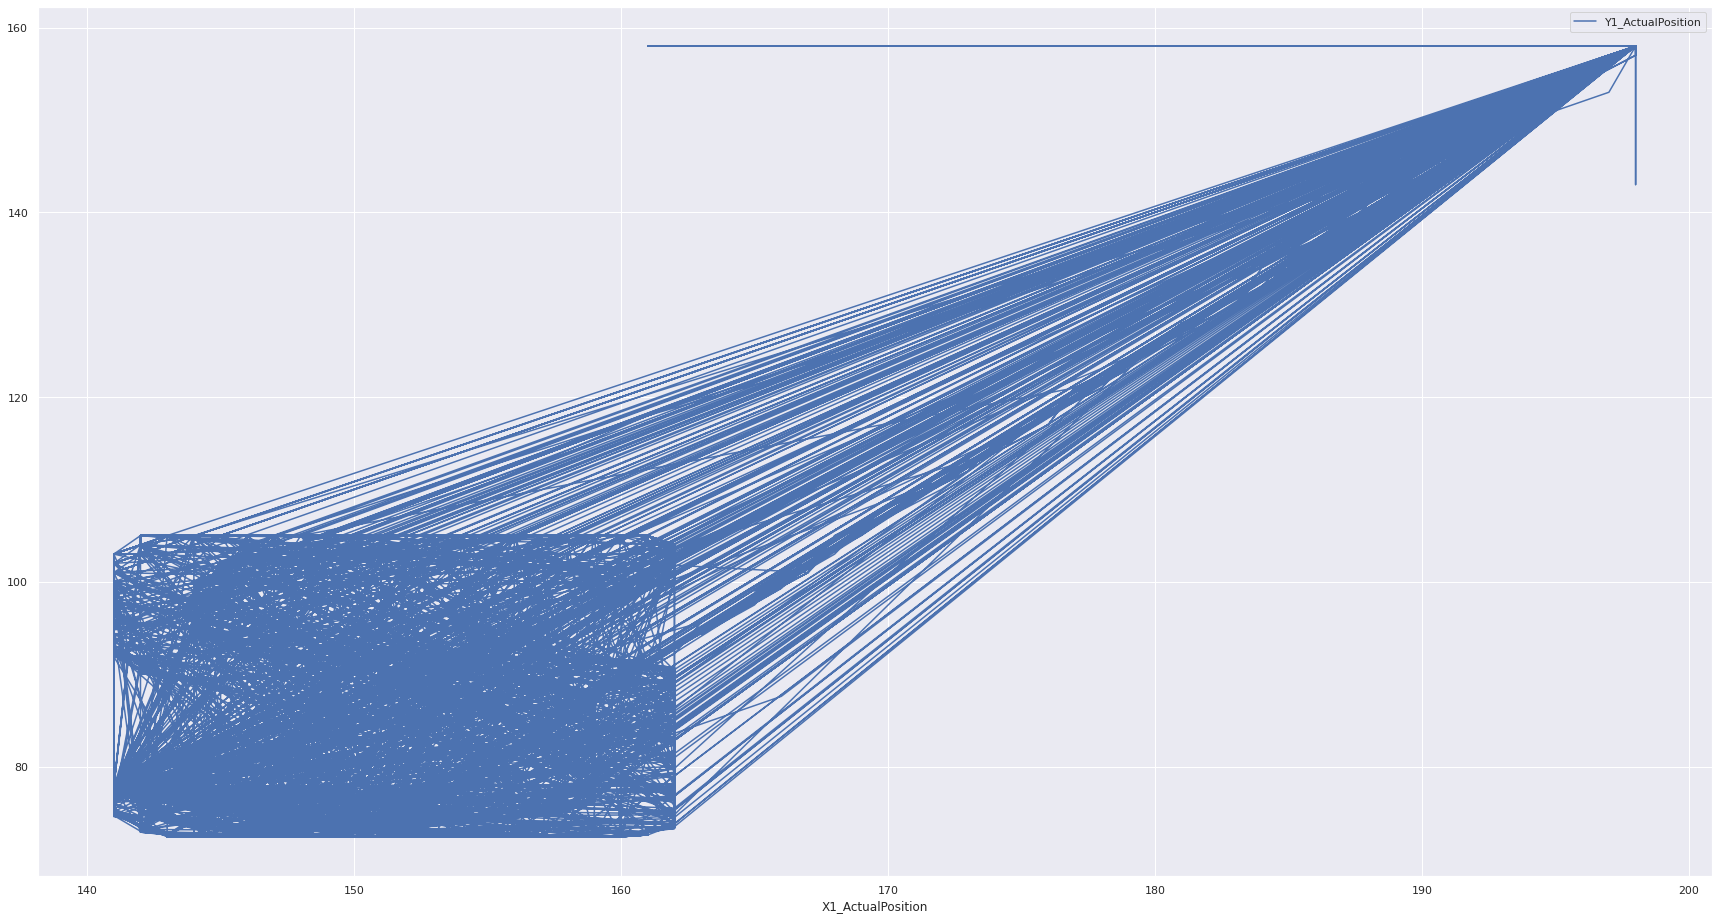

In [4]:
# add info if a step (point) is a milling one or a service one (preparation, repositioining etc.)
series['Milling'] = series['Machining_Process'].str.startswith('Layer')

# show tool trajectory - only for milling steps
series[series.Milling].plot(x='X1_ActualPosition',y='Y1_ActualPosition');


Figure above shows that my assumption about milling/preparation steps was wrong!
The "Layer..." steps clearly contain also some moving of the tool without the real contact with material.

I need to dig deeper into data to gain better understanding.

For now, lets continue only with experiment 1 as it is the one which meets my expectation...

In [5]:
# drop all experiments but No.1 (the reason is explained above)
series = series[series.Experiment == 1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


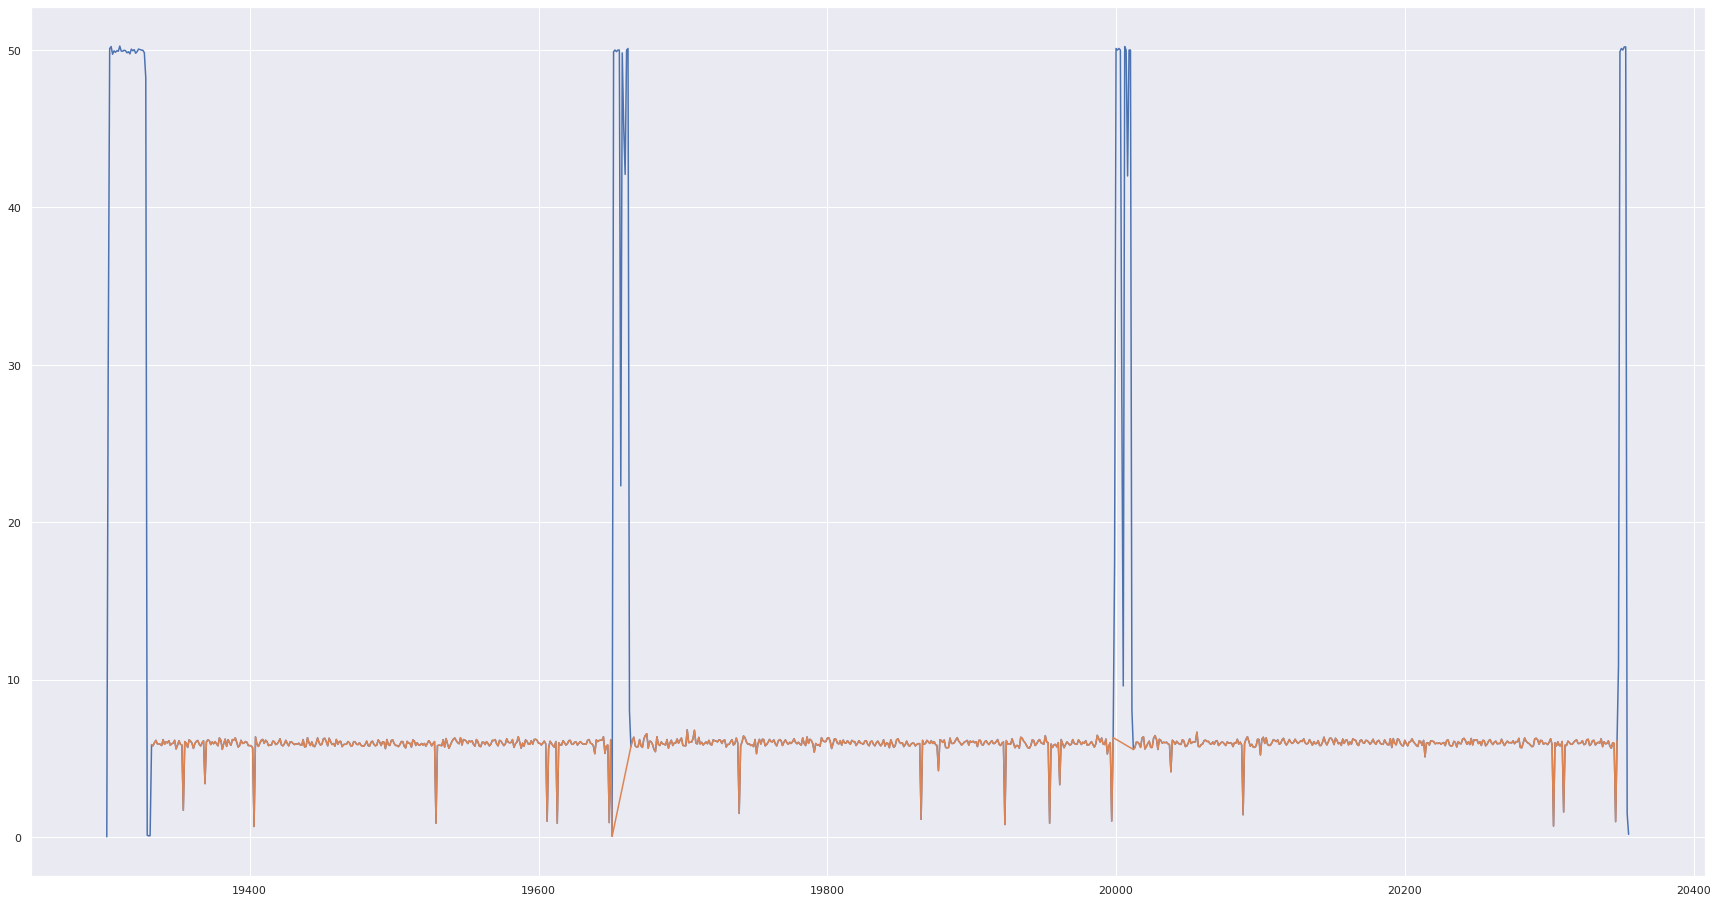

In [6]:
# add column with actual speed - regardless of direction
series['Velocity'] = np.sqrt(series['X1_ActualVelocity'] ** 2 + series['Y1_ActualVelocity'] ** 2+ series['Z1_ActualVelocity'] ** 2)
series['Velocity'].plot() # all steps - including preparation etc.
series[series.Milling]['Velocity'].plot(); # only milling steps

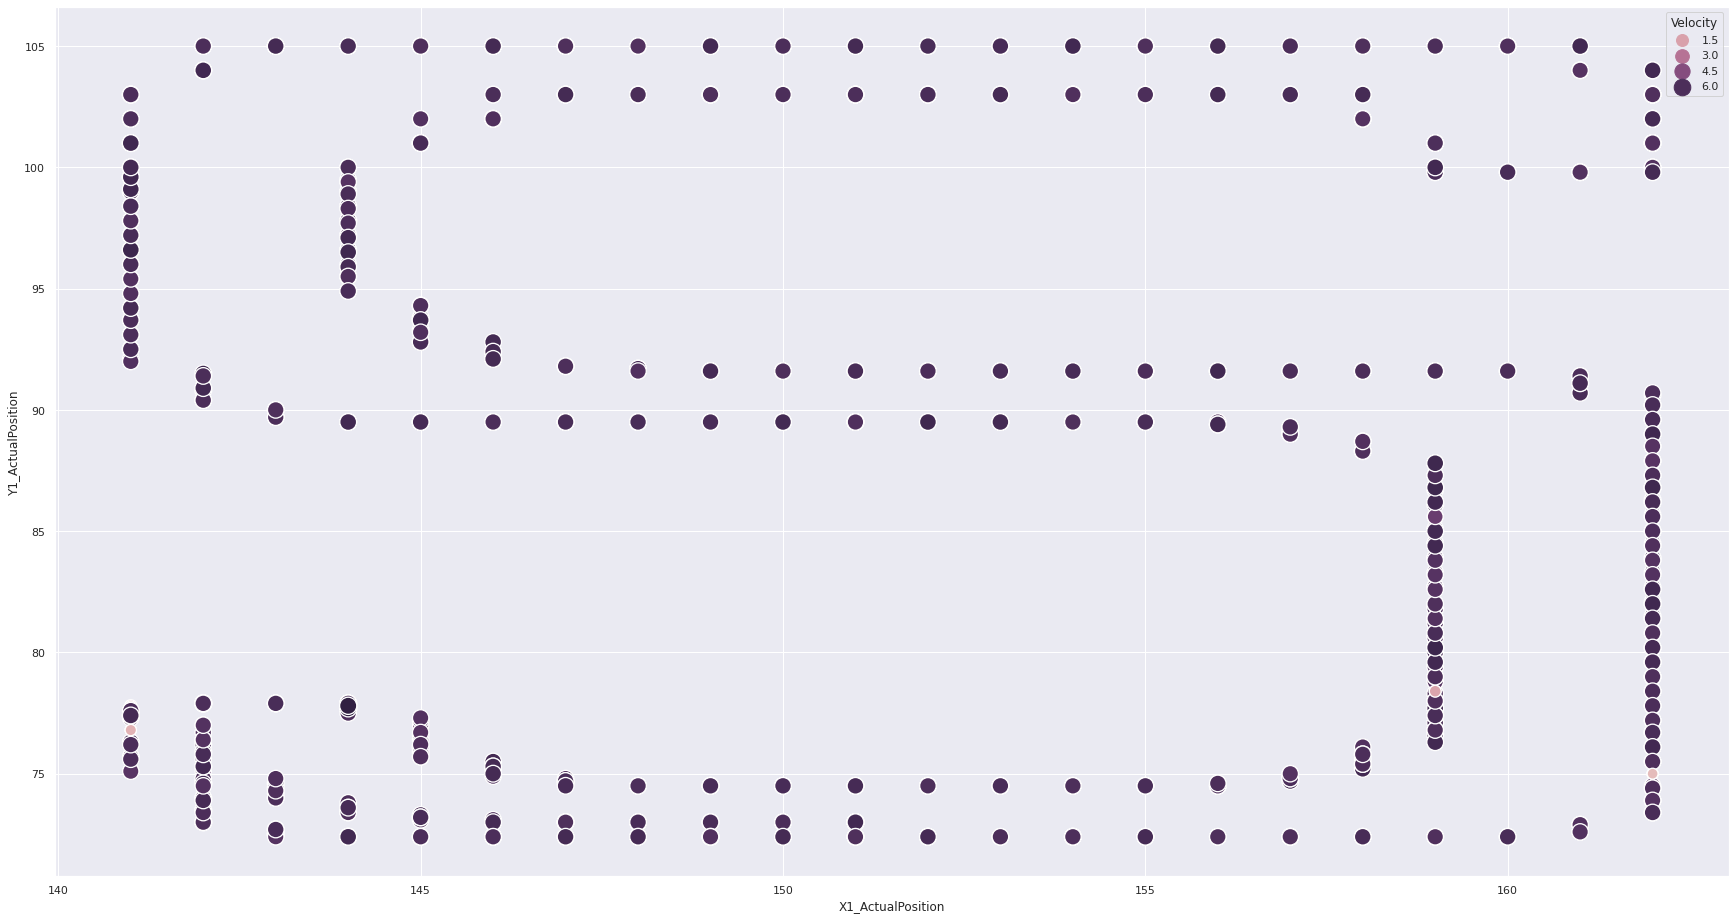

In [7]:
# show tool trajectory and use color encoding to display speed of the tool motion

sns.scatterplot(data=series[series.Milling], x='X1_ActualPosition', y='Y1_ActualPosition', hue='Velocity', size='Velocity', sizes=(100, 300));

Lets see if we can find some correlation between columns

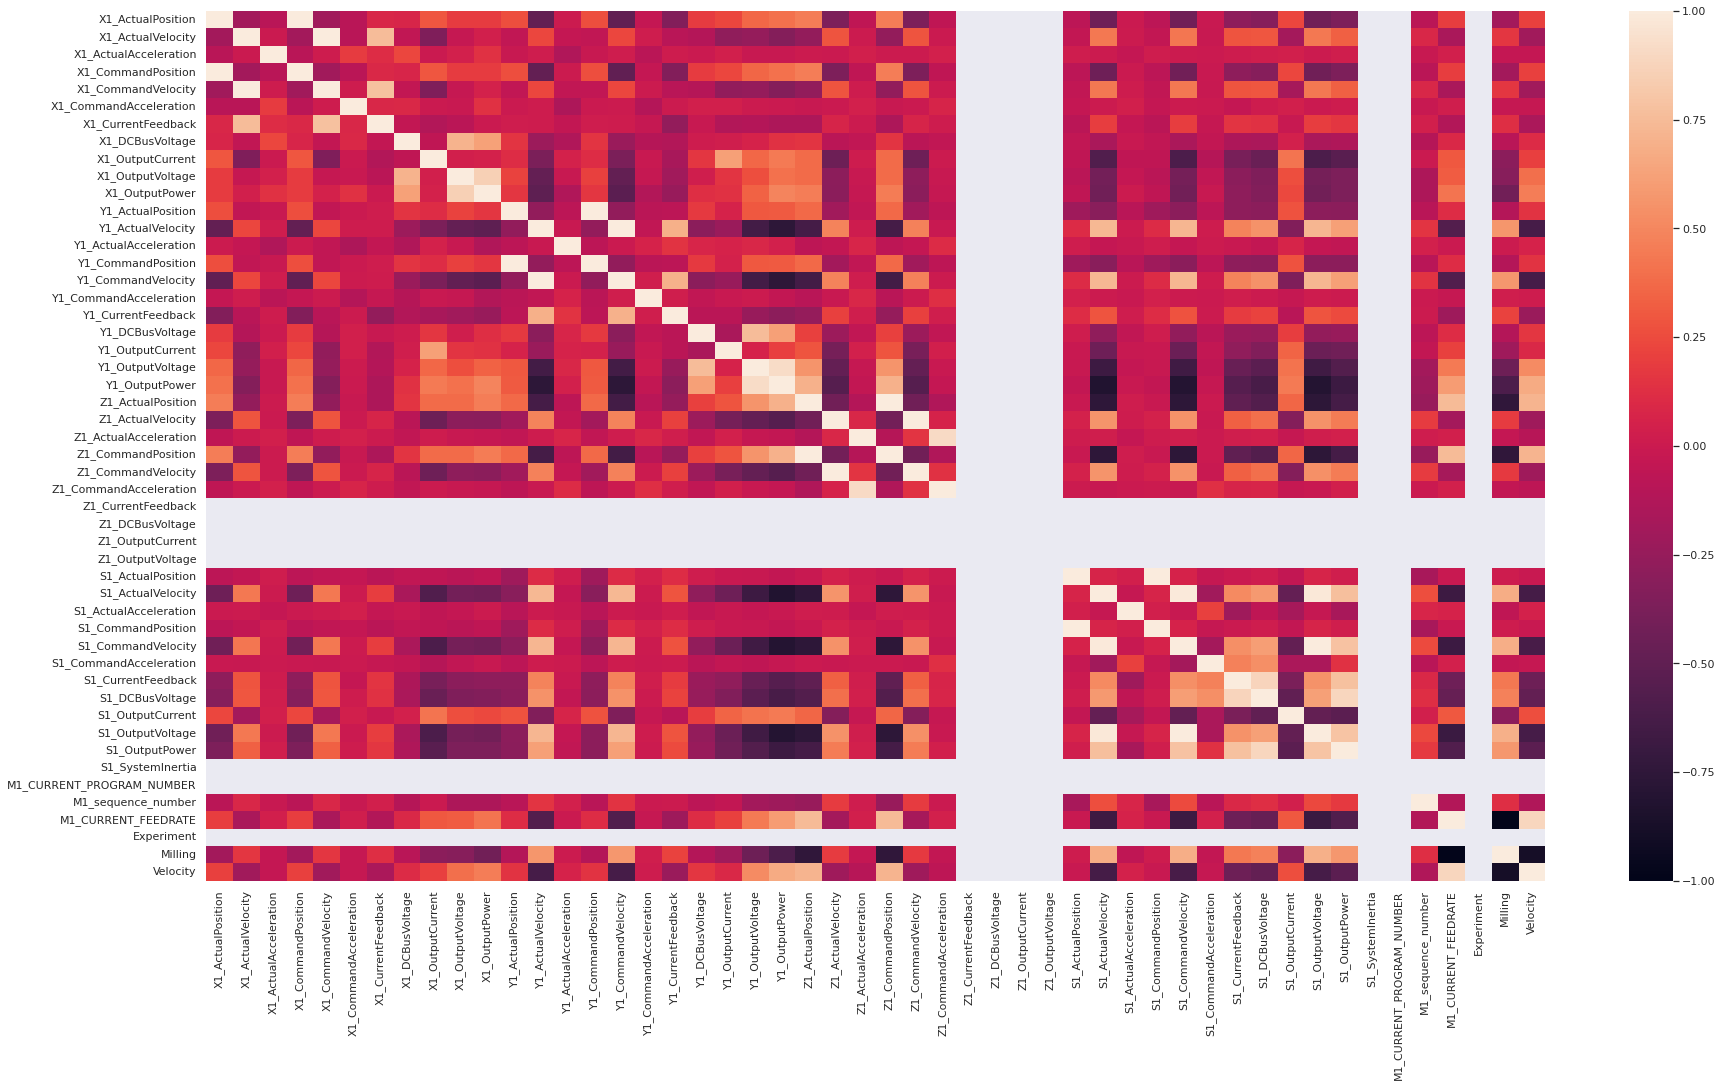

In [8]:
sns.heatmap(series.corr());

## Spindle output power vs Machining process
**Hypothesis**: Output power of the tool (S1_OutputPower) is bigger for "Milling" points than in "Preparation" ones.
Let's see if we can prove this.

In [9]:
milling_pwr = series[series.Milling]['S1_OutputPower'].mean()
not_milling_pwr = series[series.Milling == False]['S1_OutputPower'].mean()
print('Milling pwr average:' + str(milling_pwr))
print('Not Milling pwr average:' + str(not_milling_pwr))
pct = milling_pwr / not_milling_pwr * 100
pct

Milling pwr average:0.1772831483350153
Not Milling pwr average:0.08838427125625001


200.5822368790294

**Conclusion**: hypothesis was proven correct.
Average spindle power for Milling steps is two times bigger than for non Milling steps

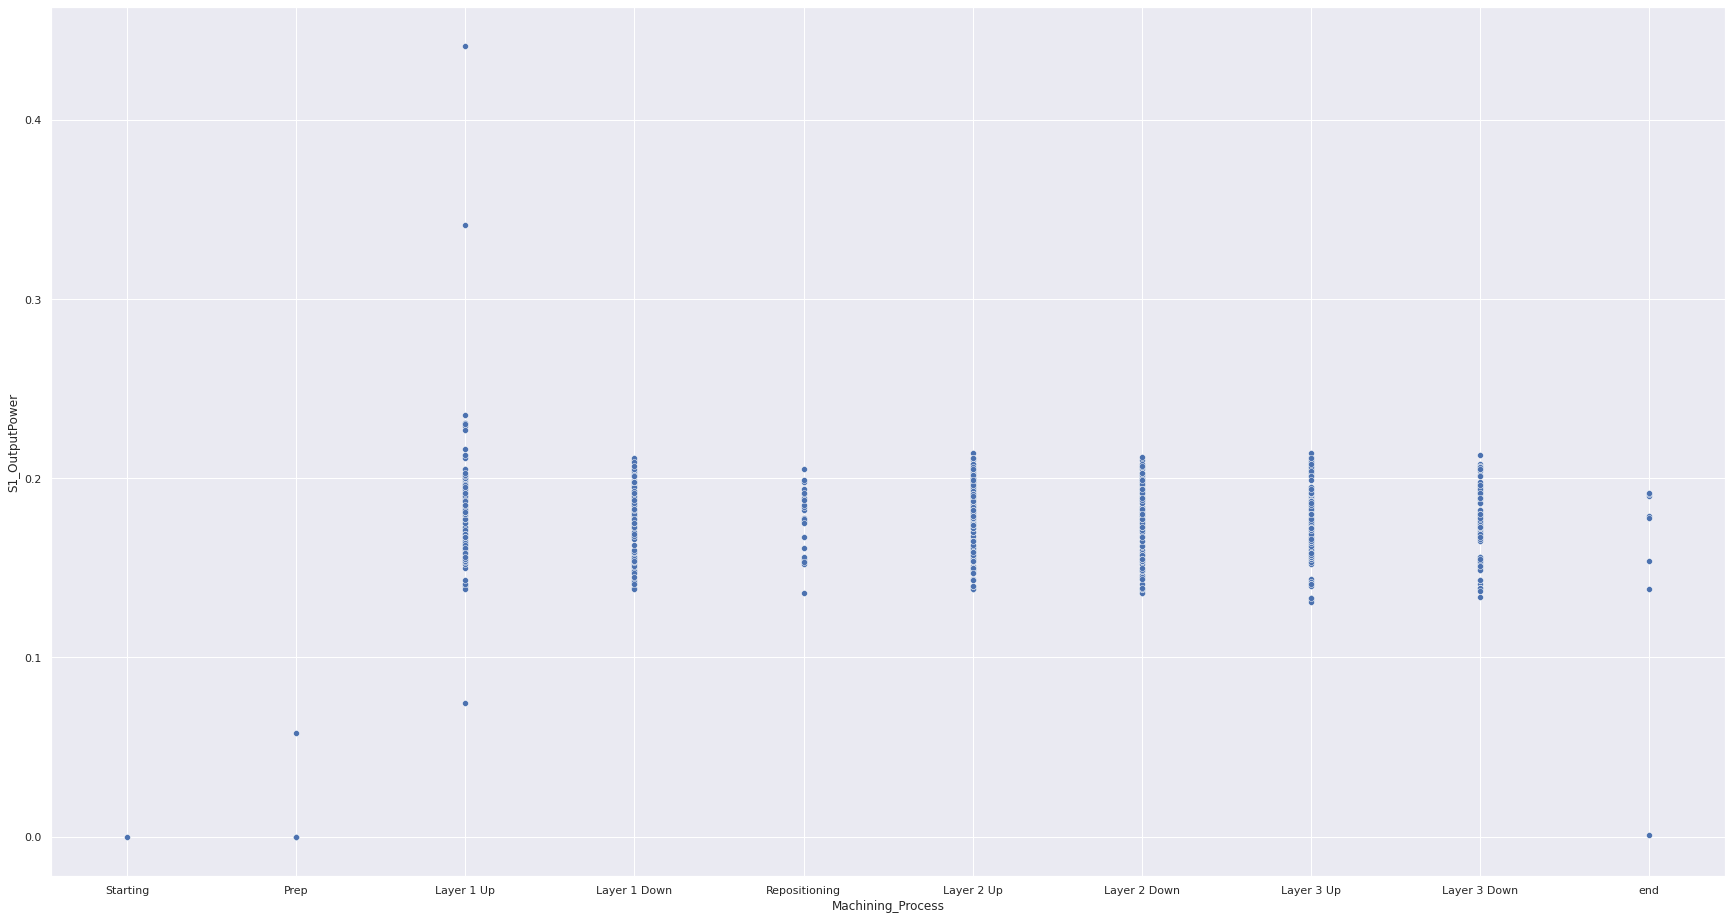

In [10]:
# lets see how the spindle power for each process step looks in graph
sns.scatterplot(data=series, x='Machining_Process', y='S1_OutputPower');